In [208]:
import itertools as it
from random import shuffle, sample
import pickle as pkl

# Upgrade version for K-means!
#!pip install threadpoolctl==3.0
#!pip install dit
import numpy as np
import pandas as pd
from joblib import Memory
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import mnist
import dit
import dit.example_dists
from dit.pid import *
from PIL import Image
import itertools
from tqdm import tqdm
from skimage import io
from sklearn.cluster import KMeans
from torchvision import datasets, transforms
from scipy.spatial.distance import pdist, squareform

In [209]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  
])

In [210]:
fashion = datasets.FashionMNIST(root="\.", download=True, train=True)
cifar_data = datasets.CIFAR10(root="\.", download=True, train=True, transform=transform)
#imagenet = datasets.CIFAR100(root="\.", download=True, train=True)

Files already downloaded and verified


In [211]:
fashion = np.array(fashion.data)
cifar_targets = np.array(cifar_data.targets)
cifar = np.array(cifar_data.data)

# ONLY CATS
cat_class = 3
cat_inds = cifar_targets == cat_class
cifar_cats = cifar[cat_inds]

In [212]:
location = './cachedir'
memory = Memory(location, verbose=0)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MNIST

I first download mnist so as to have a "fitness map" that is not random

In [213]:
mnist.init_cached = memory.cache(mnist.init)
mnist.init_cached()

In [214]:
train, _, _, _ = mnist.load()

In [215]:
mns = train.reshape(60000, 28, 28)
fashion = fashion.reshape(60000, 28, 28)

In [216]:
mns.shape, fashion[0].shape, cifar[0].shape

((60000, 28, 28), (28, 28), (32, 32, 3))

In [217]:
cifar_cats.data.shape

(5000, 32, 32, 3)

In [218]:
grey_cifar = np.mean(cifar_cats, axis=3, keepdims=True)
grey_cifar.shape

(5000, 32, 32, 1)

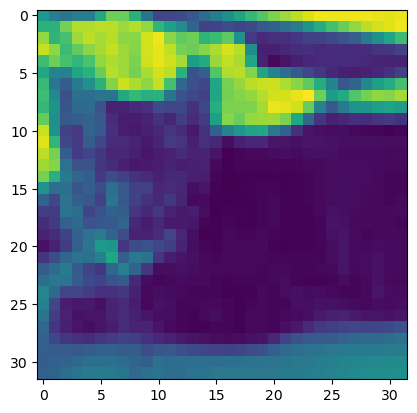

In [220]:
plt.style.use('default')
plt.imshow(grey_cifar[0])

In [223]:
DATASET = "cifar"
rgb = False

if DATASET == "mnist":
    dataset = mns
elif DATASET == "fashion":
    dataset = fashion
elif DATASET == "cifar":
    dataset = grey_cifar
    rgb = True
else:
    print("No valid dataset!!!")
    
print(DATASET)
n = 0

cifar


1


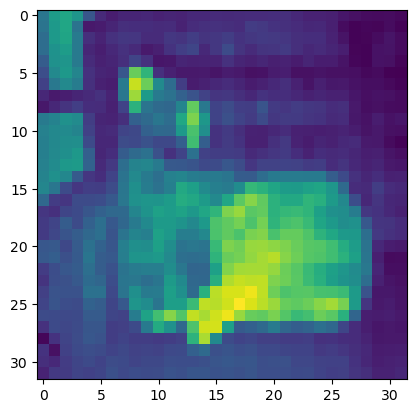

In [224]:
n += 1
print(n)
plt.imshow(dataset[n])
plt.savefig('mnistzero.png')

# The Algorithm

It would work like this:

1. Create random ENC1 and ENC2 maps
2. Calculate the decoder with MSE with these maps
3. Find a punctual change in ENC1 or ENC2 that results in a decrease in MSE
4. Repeat 3 until convergence.

In [225]:
class Algorithm:

    def __init__(self, side, signals):
        self.side = side
        self.signals = signals

    def random_enc(self):
        """
        Return a random encoding strategy that assing one of <signals> many signals
        to each of a number <side> of positions
        """
        return np.random.randint(self.signals, size=(self.side))

    def mmse_pairofsignals(self, signal1, signal2):
        """
        Calculate the mmse estimator for a pair of signals, given a fitnessmap and two encoders
        """
        iter1 = np.where(self.enc1 == signal1)[0]
        iter2 = np.where(self.enc2 == signal2)[0]
        samesignal = np.array(list(it.product(iter1, iter2)), dtype=int)
        try:
            return self.fitnessmap[samesignal[:, 0], samesignal[:, 1]]
        except IndexError:
            return np.array([])

    def mmse_decoder(self):
        """
        Calculate the mmse decoder for two encoders,
        given a fitnessmap and a maximum number of signals
        """
        # pairs: combinatorial of all possible pairs (i.e., [(0.0), (0,1), ..., (5, 5)])
        pairs = list(it.product(range(self.signals), repeat=2))
        
        # decoder: uninitialized matrix array of 28x28 (affordance reconstruction)
        decoder = np.empty((self.signals, self.signals))

        samples = []
        mse = []
        for pair in pairs:
            # *pair: unzip tuple: (0, 0) -> 0, 0
            # values: get fitness values given the signals
            values = self.mmse_pairofsignals(*pair)
            if len(values) == 0:
                continue
            # assign the mean fitness value to the decoder's position
            decoder[pair] = values.mean()
            samples.append(values.shape[0])
            # compute mean squared error
            new_mse = ((values - values.mean()) ** 2).mean()
            mse.append(new_mse)
        
        # since each "batch" might not have same size, we have to weight the contribution of each batch
        # to the global mse
        norm_samples = np.array(samples) / np.array(samples).sum()
        return decoder, np.array(mse) @ norm_samples

    def modify_enc(self, pair):
        encoders = {0:self.enc1, 1:self.enc2}
        index, enc = pair
        enc1_backup = self.enc1.copy()
        enc2_backup = self.enc2.copy()
        actual_signal = encoders[enc][index]
        loop = [signal for signal in range(self.signals) if signal != actual_signal]
        for signal in loop:
            encoders[enc][index] = signal
            decoder, mse = self.mmse_decoder()
            if mse < self.mse:
                self.mse = mse
                self.decoder = decoder
                return True
        self.enc1 = enc1_backup
        self.enc2 = enc2_backup
        return False

    def modify_full(self):
        shuffle_encoders = list(it.product(range(self.side), range(2)))
        shuffle(shuffle_encoders)
        for action in shuffle_encoders:
            result = self.modify_enc(action)
            if result:
                return action
        return False

    def main_loop(self):
        self.decoder, self.mse = self.mmse_decoder()
        action = True
        while action:
            action = self.modify_full()
        return self.mse

    def represent(self, showimage=True):
        canvass = np.empty((self.side, self.side))
        for i, j in it.product(range(self.side), repeat=2):
            canvass[i, j] = self.decoder[self.enc1[i], self.enc2[j]]
        if showimage:
            plt.imshow(canvass)
        return canvass

In [226]:
# This means, create an algorithm for a 28x28 square image, and 6 signals
algo = Algorithm(dataset[n].shape[0], 6)

In [227]:
# Start with random encoders
algo.enc1 = algo.random_enc()
algo.enc2 = algo.random_enc()

In [228]:
print("Initial random encoding 1:", algo.enc1)
print("Initial random encoding 2:", algo.enc2)

Initial random encoding 1: [5 3 2 4 0 1 4 3 5 1 4 1 0 1 5 2 3 2 5 0 1 4 0 2 3 4 4 1 2 4 1 0]
Initial random encoding 2: [3 3 4 4 1 5 5 4 0 1 3 5 1 2 3 1 2 5 4 5 4 1 0 3 5 1 3 0 3 4 2 2]


In [229]:
# Use the MNIST zero above as fitness map
algo.fitnessmap = dataset[n]

In [230]:
# algo.main_loop() is the main function, the cacheing etc is not strictly necessary
# The result is the resulting mean squared error
algo.main_loop()

284.4743352206816

Optimized encoding: [1 1 1 1 1 4 4 5 5 4 4 4 4 4 3 3 2 2 2 2 2 2 2 2 2 0 0 3 5 5 5 5]


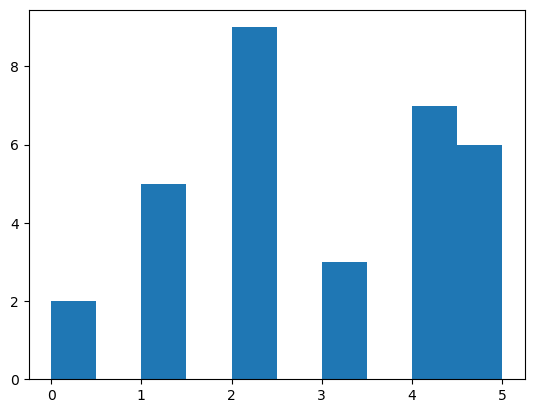

In [231]:
print("Optimized encoding:", algo.enc1)
plt.hist(algo.enc1)
plt.show()

In [232]:
algo.enc2

array([5, 5, 5, 5, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 2, 4, 4, 4])

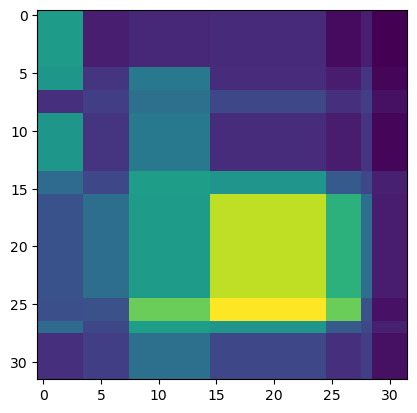

In [233]:
# The reconstructed fitness map
array = algo.represent()

# Fitness optimization in one go

One other simple thing before I take up the question of synergic content: directly optimizing for fitness.

That is to say, now there's one encoder that sees the whole "global array"

In [234]:
class Single_Enc(Algorithm):

    def random_single_enc(self):
        """
        Return a random encoding strategy that assing one of <signals> many signals
        to each of a number <side * side> of positions
        """
        return np.random.randint(self.signals, size=(self.side, self.side))

    def mmse_onesignal(self, signal):
        """
        Calculate the mmse estimator for a signal, given a fitnessmap and an encoders
        """
        axis1, axis2 = np.where(self.enc == signal)
        try:
            return self.fitnessmap[axis1, axis2]
        except IndexError:
            return np.array([])

    def mmse_decoder(self):
        """
        Calculate the mmse decoder for one encoders,
        given a fitnessmap and a maximum number of signals
        """
        decoder = np.empty((self.signals))
        samples = []
        mse = []
        for signal in range(self.signals):
            values = self.mmse_onesignal(signal)
            decoder[signal] = values.mean()
            samples.append(values.shape[0])
            new_mse = ((values - values.mean()) ** 2).mean()
            mse.append(new_mse)
        norm_samples = np.array(samples) / np.array(samples).sum()
        return decoder, np.array(mse) @ norm_samples

    def modify_enc(self, index):
        enc_backup = self.enc.copy()
        actual_signal = self.enc[index]
        loop = [signal for signal in range(self.signals) if signal != actual_signal]
        for signal in loop:
            self.enc[index] = signal
            decoder, mse = self.mmse_decoder()
            if mse < self.mse:
                self.mse = mse
                self.decoder = decoder
                return True
        self.enc = enc_backup
        return False

    def modify_full(self):
        shuffle_encoder = list(it.product(range(self.side), repeat=2))
        shuffle(shuffle_encoder)
        for action in shuffle_encoder:
            result = self.modify_enc(action)
            if result:
                return action
        return False

    def represent(self):
        canvass = np.empty((self.side, self.side))
        for i, j in it.product(range(self.side), repeat=2):
            canvass[i, j] = self.decoder[self.enc[i,j]]
        plt.imshow(canvass)
        return canvass

In [235]:
# Just two signals, so we'll get a "black and white" reconstructed fitness map
single = Single_Enc(dataset[n].shape[0], 2)

In [236]:
single.enc = single.random_single_enc()

In [237]:
single.fitnessmap = dataset[n]

In [238]:
# With just two signals we get much better error than with 6 signals above
# (because we can observe everything at the same time)

single.main_loop()

444.41354626343497

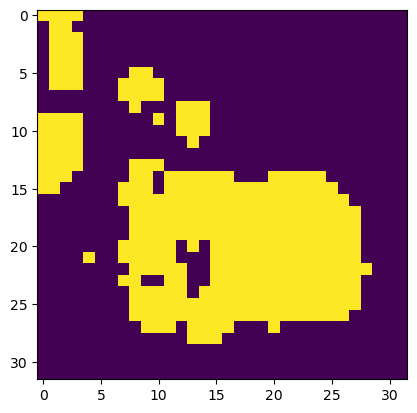

In [239]:
array = single.represent()

In [240]:
#cat_single.main_loop()

In [241]:
#cat_single_arr = cat_single.represent()

In [242]:
"""plt.subplot(1, 2, 1)
plt.imshow(groundtruth)
plt.subplot(1, 2, 2)
plt.imshow(cat_single_arr)
plt.savefig("cat_onestream.pdf")"""

'plt.subplot(1, 2, 1)\nplt.imshow(groundtruth)\nplt.subplot(1, 2, 2)\nplt.imshow(cat_single_arr)\nplt.savefig("cat_onestream.pdf")'

# Correlation (or lack thereof) between synergy and information of the signals

Now, it is to be expected that, if the signals of enc1 and enc2 are to maximize information about a fitness value, they will carry more information about the values of the x and y axes than about fitness. I'll test this now.

The first, easy thing is to calculate the maximum information that one signal alone can carry about fitness, and how much info that signal carries about the axis.

In [293]:
class Single_Enc_One_Side(Algorithm):

    def random_single_enc(self):
        """
        Return a random encoding strategy that assing one of <signals> many signals
        to each of a number <side * side> of positions
        """
        return np.random.randint(self.signals, size=(self.side))

    def mmse_onesignal(self, signal):
        """
        Calculate the mmse estimator for a signal, given a fitnessmap and an encoders
        """
        axis = np.where(self.enc == signal)
        try:
            return self.fitnessmap[axis]
        except IndexError:
            return np.array([])

    def mmse_decoder(self):
        """
        Calculate the mmse decoder for one encoders,
        given a fitnessmap and a maximum number of signals
        """
        decoder = np.empty((self.signals))
        samples = []
        mse = []
        for signal in range(self.signals):
            values = self.mmse_onesignal(signal)
            if len(values) == 0:
                continue
            decoder[signal] = values.mean()
            samples.append(values.shape[0])
            new_mse = ((values - values.mean()) ** 2).mean()
            mse.append(new_mse)
        norm_samples = np.array(samples) / np.array(samples).sum()
        return decoder, np.array(mse) @ norm_samples

    def modify_enc(self, index):
        enc_backup = self.enc.copy()
        actual_signal = self.enc[index]
        loop = [signal for signal in range(self.signals) if signal != actual_signal]
        for signal in loop:
            self.enc[index] = signal
            decoder, mse = self.mmse_decoder()
            if mse < self.mse:
                self.mse = mse
                self.decoder = decoder
                return True
        self.enc = enc_backup
        return False

    def modify_full(self):
        shuffle_encoder = list(range(self.side))
        shuffle(shuffle_encoder)
        for action in shuffle_encoder:
            result = self.modify_enc(action)
            if result:
                return result
        return False

    def main_loop(self):
        self.decoder, self.mse = self.mmse_decoder()
        action = True
        while action:
            action = self.modify_full()
        return self.mse

    def main(self, enc2, enc1):
        self.enc = enc1
        self.main_loop()
        self.mse1 = self.mse
        self.enc1 = self.enc
        self.decoder1 = self.decoder
        self.mse = 1e6
        self.fitnessmap = self.fitnessmap.T
        self.enc = enc2
        self.main_loop()
        self.mse2 = self.mse
        self.enc2 = self.enc
        self.decoder2 = self.decoder
        self.fitnessmap = self.fitnessmap.T
        return True

    def represent_2(self, showimage=True):
        canvass = np.empty((self.side, self.side))
        for i, j in it.product(range(self.side), repeat=2):
            canvass[j, i] = self.decoder2[self.enc2[i]]
        if showimage:
            plt.imshow(canvass)
        return canvass

    def represent_1(self, showimage=True):
        canvass = np.empty((self.side, self.side))
        for i, j in it.product(range(self.side), repeat=2):
            canvass[i, j] = self.decoder1[self.enc1[i]]
        if showimage:
            plt.imshow(canvass)
        return canvass
    
    def get_decoders(self):
        new_enc1 = np.empty(shape=self.enc1.shape)
        new_enc2 = np.empty(shape=self.enc2.shape)
        for i in range(len(self.decoder1)):
            inds1 = self.enc1 == i
            inds2 = self.enc2 == i
            
            new_enc1[inds1] = self.decoder1[i]
            new_enc2[inds2] = self.decoder2[i]
            
        return new_enc1, new_enc2

    def get_affordance_encodings(self):
        encoding = []
        for i,tup1 in enumerate(self.decoder1):
            inds = list(it.product([tup1],self.decoder2))
            for j,ind in enumerate(inds):
                encod = self.fitnessmap[i][j]
                encoding.append((str(ind[0]), str(ind[1]), str(encod)))
       
        return encoding
    
    def get_sensory_encodings(self):  
        encoding = [(str(x), str(self.decoder2[i]), str(y))
                    for i,(x,y) in enumerate(list(zip(self.decoder1, self.fitnessmap)))]
        return encoding
    
    def get_pid_measures(self, n, encoding, show=True):
        pid_myopic = dit.Distribution(encoding, [1/len(encoding)]*len(encoding))
        pid_myopic.set_rv_names(list(range(n)))
        
        pid_measure = PID_BROJA(pid_myopic)
        
        pid_names = ["{0}", "{1}", "{0}{1}", "{0:1}"]
        pid_dict = {}
        for i,k in enumerate(pid_measure._pis.keys()):
            value = pid_measure.get_pi(k)
            pid_dict[pid_names[i]] = value
        
        if show:
            print("PID BROJA:\n", pid_measure)
        
        return pid_dict
    
        
    def get_mutual_info(self):
        encoding_1 = [(str(x), str(y)) for (x,y) in list(zip(self.decoder1, self.fitnessmap))]
        encoding_2 = [(str(x), str(y)) for (x,y) in list(zip(self.decoder2, self.fitnessmap))]
        
        dist_enc_1 = dit.Distribution(encoding_1, [1/len(encoding_1)]*len(encoding_1))
        dist_enc_2 = dit.Distribution(encoding_2, [1/len(encoding_2)]*len(encoding_2))
        
        mutual_1 = dit.shannon.mutual_information(dist_enc_1, [0], [1])
        mutual_2 = dit.shannon.mutual_information(dist_enc_2, [0], [1])
        
        return mutual_1, mutual_2, dist_enc_1, encoding_1
    
    def get_entropy(self, distribution):

        # Calculate the frequency distribution
        unique_values, counts = np.unique(distribution.flatten(), return_counts=True)
        
        #distribution_dict = dict(zip(map(str, unique_values), counts/len(self.fitnessmap.flatten())))
        distribution_dict = dict(zip(map(lambda x: (str(x),), unique_values), counts/len(distribution.flatten())))
                
        entropy_fitness = dit.Distribution(distribution_dict)
        
        return dit.shannon.entropy(entropy_fitness)
    
def merge_dicts(dicts):
    merged_dict = {}
    for key in dicts[0].keys():
        merged_dict[key] = [d[key] for d in dicts]

    return merged_dict

In [254]:
def distribution_signals(dist_inp, total_range):
    dist = {n:0. for n in total_range}
    for x in dist_inp:
        dist[x] = dist.get(x,0) + 1
        
    for k,v in dist.items():
        dist[k] = v/dist_inp.shape[0]
    
    return dist

In [255]:
def plot_dist_signals(dists):
    plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    inds = list(itertools.product([0,1], [0,1]))
    
    for i,(n,d) in enumerate(dists.items()):
        axs[inds[i]].bar(x=list(d.keys()), height=list(d.values()))
        axs[inds[i]].set_title(n)
        axs[inds[i]].set_yticks(np.arange(0, 0.71, 0.1))
        
    plt.show()

In [256]:
def quantize_fitnessmaps(fm, n_colors):

    arr = fm.reshape((-1, 1))
    kmeans = KMeans(n_clusters=n_colors, random_state=1).fit(arr)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    less_colors = centers[labels].reshape(fm.shape).astype('uint8')

    return less_colors

In [247]:
def plot_results(ax, df, columns, name_value, title):
    plt.style.use('seaborn')
    # Calculate mean and standard deviation for each signal and MSE column
    means = df.groupby('Signal').mean()
    stds = df.groupby('Signal').std()

    # Reshape the DataFrame for Seaborn
    df_seaborn = pd.melt(df[["Signal"] + columns], id_vars='Signal', var_name=name_value, value_name='Value')

    # Plotting using Seaborn
    #plt.figure(figsize=(10, 6))
    sns.lineplot(x='Signal', y='Value', hue=name_value, data=df_seaborn, ci='sd', marker='o', ax=ax)

    # Set labels and title
    ax.set_xlabel('Signal', fontsize=18)
    ax.set_ylabel(name_value, fontsize=18)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title(title, fontsize=20)

    ax.legend(bbox_to_anchor=(0.9, 1), loc='upper left', fontsize=16)

In [292]:
def get_spatial_entropy(dist, num_signals):
    """
    Spatial entropy measure by: Claramunt, C. (2005). A spatial form of diversity
    The OFF data is not used for the final computation since we are only interested in the distribution of
    ON signals. Adding the OFF terms biases the spatial entropy in an undesired way.
    """
    
    total_categories = len(dist.keys())
    category = []
    prob_ON = []
    prob_OFF = []
    
    for k,v in dist.items():
        if v != 0:
            category.append("ON")
            prob_ON.append(v)
        else:
            prob_OFF.append(1/total_categories)
            category.append("OFF")
    
    prob_ON = np.array(prob_ON)
    prob_OFF = np.array(prob_OFF)
    
    df = pd.DataFrame({
        'x': list(dist.keys()),
        'class': category
    })
    

    # Extract intra and extra distances from a Euclidean distance matrix
    dist_matrix = pd.DataFrame(np.linalg.norm(df[['x', 'x']].values - df[['x', 'x']].values[:, None], axis=-1))

    # Intra-distance for each class
    intra = [dist_matrix.loc[df['class'] == let, df['class'] == let].values for let in ['ON', 'OFF']]
    
    # Extra-distance for each class
    extra = [dist_matrix.loc[df['class'] == let, df['class'] != let].values for let in ['ON', 'OFF']]

    # Average Intra-distance for each class
    intra_green = np.mean(intra[0][intra[0] != 0])
    intra_white = np.mean(intra[1][intra[1] != 0])

    # Average Extra-distance for each class
    extra_green = np.mean(extra[0][extra[0] != 0])
    extra_white = np.mean(extra[1][extra[1] != 0])

    # Average Extra-distance for ON and OFF classes
    extra_ON = np.mean(extra[0][extra[0] != 0])
    extra_OFF = np.mean(extra[1][extra[1] != 0])

    # Average Intra-distance for ON class
    intra_ON = np.mean(intra[0][intra[0] != 0])

    # Average Intra-distance for OFF
    intra_OFF = np.mean(intra[1][intra[1] != 0])

    # Entropy for each class
    entropy_ON = prob_ON * np.log2(1/prob_ON)
    entropy_OFF = prob_OFF * np.log2(1/prob_OFF)

    # Claramunt's entropy ratios (intra/extra)
    ON_CL = intra_ON / extra_ON
    OFF_CL = intra_OFF / extra_OFF
    
    # Claramunt's spatial entropy
    spatial_entropy = np.sum(entropy_ON * ON_CL)
    
    return spatial_entropy

In [249]:
def get_results(fitnessmaps, total_signals, rgb, n=3,
                show_fit=False, showimage=False, show_pid=False,
                verbose=False, plot_dists=False):
    
    ts = len(total_signals)
    repeats = len(fitnessmaps)*len(total_signals)
    
    signals = []
    mse1_avg = []
    mse2_avg = []
    msi1_avg = []
    msi2_avg = []
    ment1_avg = []
    ment2_avg = []
    mre_avg = []
    msyn_avg = []
    
    gse1_avg = []
    gse2_avg = []
    gsi1_avg = []
    gsi2_avg = []
    gent1_avg = []
    gent2_avg = []
    gre_avg = []
    gsyn_avg = []
    
    if rgb:
        fitnessmaps = [quantize_fitnessmaps(fm, n) for fm in fitnessmaps] 
    
    for s,num_signals in enumerate(total_signals):
        
        print("\nSignal", num_signals)
        
        for r, fitnessmap in tqdm(enumerate(fitnessmaps)):

            oneside = Single_Enc_One_Side(fitnessmap.shape[0], num_signals)
            oneside.fitnessmap = fitnessmap
            oneside.main(oneside.random_single_enc(), oneside.random_single_enc())
            
            if verbose and s == 0:
                print(f"Entropy of fitnessmap: {oneside.get_entropy(): .2f}")
                pass

            if show_fit and s == 0:
                plt.style.use('default')
                plt.title("Fitness Map")
                io.imshow(fitnessmap)
                plt.show()

            ##########
            # MYOPIC #
            ##########
            # Get sensory information and MSE for the MYOPIC encoders                
            oneside.fitnessmap = np.arange(oneside.side)
                        
            oneside.enc = oneside.enc1
            #myopic1 = oneside.enc
            decoder_myopic_1, mse_myopic_sensory_1 = oneside.mmse_decoder()
            
            oneside.enc = oneside.enc2
            #myopic2 = oneside.enc
            decoder_myopic_2, mse_myopic_sensory_2 = oneside.mmse_decoder()
            
            decoder_myopic_1 = np.round(decoder_myopic_1)
            decoder_myopic_2 = np.round(decoder_myopic_2)
            
            oneside.decoder1 = decoder_myopic_1
            oneside.decoder2 = decoder_myopic_2
            dec_myopic_1, dec_myopic_2 = oneside.get_decoders()
            
            oneside.decoder1 = dec_myopic_1
            oneside.decoder2 = dec_myopic_2
            
            # PID encoders
            myopic_sensory_encoding = oneside.get_sensory_encodings()
            pid_sensory_myopic = oneside.get_pid_measures(3, myopic_sensory_encoding, show=show_pid)
            pid_sensory_myopic['{0}'] = oneside.get_mutual_info()[0]
            pid_sensory_myopic['{1}'] = oneside.get_mutual_info()[1]

            # Get affordance information and MSE for the MYOPIC encoders
            algo = Algorithm(fitnessmap.shape[0], num_signals)
            algo.fitnessmap = fitnessmap
            algo.enc1 = oneside.enc1
            algo.enc2 = oneside.enc2
            algo.decoder, algo.mse = algo.mmse_decoder()
            recons_error_myopic = round(algo.mse, 3)
            repmyopic = algo.represent(showimage=showimage)
            
            # PID synergy
            oneside.fitnessmap = fitnessmap
            myopic_affordance_encoding = oneside.get_affordance_encodings()
            pid_affordance_myopic = oneside.get_pid_measures(3, myopic_affordance_encoding, show=show_pid)

            if verbose:
                print(f"MSE encoder 1 - basic property 1: {mse_myopic_sensory_1: .2f}")
                print(f"MSE encoder 2 - basic property 2: {mse_myopic_sensory_2: .2f}")
                print(f"MI encoder 1 - basic property 1: {pid_sensory_myopic['{0}']: .2f}")
                print(f"MI encoder 2 - basic property 2: {pid_sensory_myopic['{1}']: .2f}")
                print(f"MYOPIC. Affordance reconstruction error: {recons_error_myopic: .2f}")


            ##########
            # 'GOOD' #
            ##########            
            algo.enc1 = oneside.random_enc()
            algo.enc2 = oneside.random_enc()
            recons_error_good = algo.main_loop()

            oneside.fitnessmap = np.arange(oneside.side)
            # get mse for each encoder its basic property
            oneside.enc = algo.enc1
            decoder_synergy_1, mse_synergy_sensory_1 = oneside.mmse_decoder()
            oneside.enc = algo.enc2
            decoder_synergy_2, mse_synergy_sensory_2 = oneside.mmse_decoder()

            oneside.enc1 = algo.enc1
            oneside.enc2 = algo.enc2
            
            decoder_synergy_1 = np.round(decoder_synergy_1)
            decoder_synergy_2 = np.round(decoder_synergy_2)
            
            oneside.decoder1 = decoder_synergy_1
            oneside.decoder2 = decoder_synergy_2
            dec_synergy_1, dec_synergy_2 = oneside.get_decoders()

            oneside.decoder1 = dec_synergy_1
            oneside.decoder2 = dec_synergy_2
                        
            synergy_sensory_encoding = oneside.get_sensory_encodings()
            pid_sensory_synergy = oneside.get_pid_measures(3, synergy_sensory_encoding, show=show_pid)
            pid_sensory_synergy['{0}'] = oneside.get_mutual_info()[0]
            pid_sensory_synergy['{1}'] = oneside.get_mutual_info()[1]

            oneside.fitnessmap = fitnessmap
            syenergy_affordance_encoding = oneside.get_affordance_encodings()
            pid_affordance_synergy = oneside.get_pid_measures(3, syenergy_affordance_encoding, show=show_pid)
    

            if verbose:
                print(f"\nMSE encoder 1 - basic property 1: {mse_synergy_sensory_1: .2f}")
                print(f"MSE encoder 2 - basic property 2: {mse_synergy_sensory_2: .2f}")
                print(f"MI encoder 1 - basic property 1: {pid_sensory_synergy['{0}']: .2f}")
                print(f"MI encoder 2 - basic property 2: {pid_sensory_synergy['{1}']: .2f}")
                print(f"GOOD. Affordance reconstruction error: {recons_error_good: .2f}")
            
            
            total_range = np.arange(oneside.side)
            dist_myopic_1 = distribution_signals(dec_myopic_1, total_range)
            dist_myopic_2 = distribution_signals(dec_myopic_2, total_range)

            dist_synergy_1 = distribution_signals(dec_synergy_1, total_range)
            dist_synergy_2 = distribution_signals(dec_synergy_2, total_range)

            spatial_entropy_myopic_1 = get_spatial_entropy(dist_myopic_1, num_signals)
            spatial_entropy_myopic_2 = get_spatial_entropy(dist_myopic_2, num_signals)
            spatial_entropy_synergy_1 = get_spatial_entropy(dist_synergy_1, num_signals)
            spatial_entropy_synergy_2 = get_spatial_entropy(dist_synergy_2, num_signals)
                
            if plot_dists:
                print(spatial_entropy_myopic_1)
                print(spatial_entropy_myopic_2)
                print(spatial_entropy_synergy_1)
                print(spatial_entropy_synergy_2)

                plot_dist_signals({"Encoder_myopic_1": dist_myopic_1,
                                   "Encoder_myopic_2": dist_myopic_2,
                                   "Encoder_synergy_1": dist_synergy_1,
                                   "Encoder_synergy_2": dist_synergy_2})
            
            
            signals.append(num_signals)
            mse1_avg.append(mse_myopic_sensory_1)
            mse2_avg.append(mse_myopic_sensory_2)
            msi1_avg.append(pid_sensory_myopic['{0}'])
            msi2_avg.append(pid_sensory_myopic['{1}'])
            ment1_avg.append(spatial_entropy_myopic_1)
            ment2_avg.append(spatial_entropy_myopic_2)
            mre_avg.append(recons_error_myopic)
            msyn_avg.append(pid_affordance_myopic['{0:1}'])

            gse1_avg.append(mse_synergy_sensory_1)
            gse2_avg.append(mse_synergy_sensory_2)
            gsi1_avg.append(pid_sensory_synergy['{0}'])
            gsi2_avg.append(pid_sensory_synergy['{1}'])
            gent1_avg.append(spatial_entropy_synergy_1)
            gent2_avg.append(spatial_entropy_synergy_2)
            gre_avg.append(recons_error_good)
            gsyn_avg.append(pid_affordance_synergy['{0:1}'])
            
    df = pd.DataFrame({
                        "Signal": signals,
                        # MSE sensory signals
                        "MSE_sensory_myopic_1": mse1_avg,
                        "MSE_sensory_myopic_2": mse2_avg,
                        "MSE_sensory_synergy_1": gse1_avg,
                        "MSE_sensory_synergy_2": gse2_avg,
                        # MI sensory signals
                        "MI_sensory_myopic_1": msi1_avg,
                        "MI_sensory_myopic_2": msi2_avg,
                        "MI_sensory_synergy_1": gsi1_avg,
                        "MI_sensory_synergy_2": gsi2_avg,
                        # Spatial Entropy sensory signals
                        "SENT_sensory_myopic_1": ment1_avg,
                        "SENT_sensory_myopic_2": ment2_avg,
                        "SENT_sensory_synergy_1": gent1_avg,
                        "SENT_sensory_synergy_2": gent2_avg,
                        # MSE affordance
                        "MSE_affordance_myopic": mre_avg,
                        "MSE_affordance_synergy": gre_avg,
                        # Synergy affordance
                        "Synergy_affordance_myopic": msyn_avg,
                        "Synergy_affordance_synergy": gsyn_avg,
        
                    })
        
    return df

## Experiment using a set of random fitnessmaps to evaluate the myopic and synergistic encoder using different signals
### The PID computation for signals > 6 will take quite a bit of time for CIFAR images

I'm taking the distribution of signals after the decoder's mapping. Why? To account for the information shared between encoder and decoder. For instance, if signal 0 -> 1.5 and signal 1 -> 1.5, then the decoder's entropy will be zero, while the encoder's entropy will be 1 bit.

In [250]:
signals = [2, 4, 6]
ind_images = np.random.choice(list(range(len(dataset))), size=(10))
print(ind_images)
fitness_maps = dataset[ind_images]

"""rgb: if the image is rgb, we quantize it to reduce the number of possible pixel values
        to make the PID computaion tractable. Method: K-means
   n: number of different clusters (i.e., pixel values) of K-means
   show_fit: plot fitnessmap
   verbose: show data
   show_pid: plot PID
   plot_dists: plot distribution of signals per encoder
"""

df = get_results(fitness_maps, signals, rgb=rgb, n=3,
                               show_fit=False, verbose=False,
                               show_pid=False, plot_dists=False)

[ 898 4922 1504 3003 2067  867  163 3483 3865 2738]

Signal 2


10it [00:05,  1.71it/s]



Signal 4


10it [00:33,  3.34s/it]



Signal 6


10it [01:58, 11.88s/it]


## Legend
**MSE_sensor**: MSE between each encoder (myopic and synergsitic) and its sensory modality\
**MI_sensory**: Mutual Information between each encoder (myopic and synergsitic) and its sensory modality\
**SENT_senso**: Spatial Entropy between each encoder (myopic and synergsitic) and its sensory modality\
**MSE_afford**: MSE of affordance for pairs of myopic and synergsitic encoders-decoders\
**Synergy_af**: Syenrgsitic information between the encoders and the affordance vlaue

[(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]


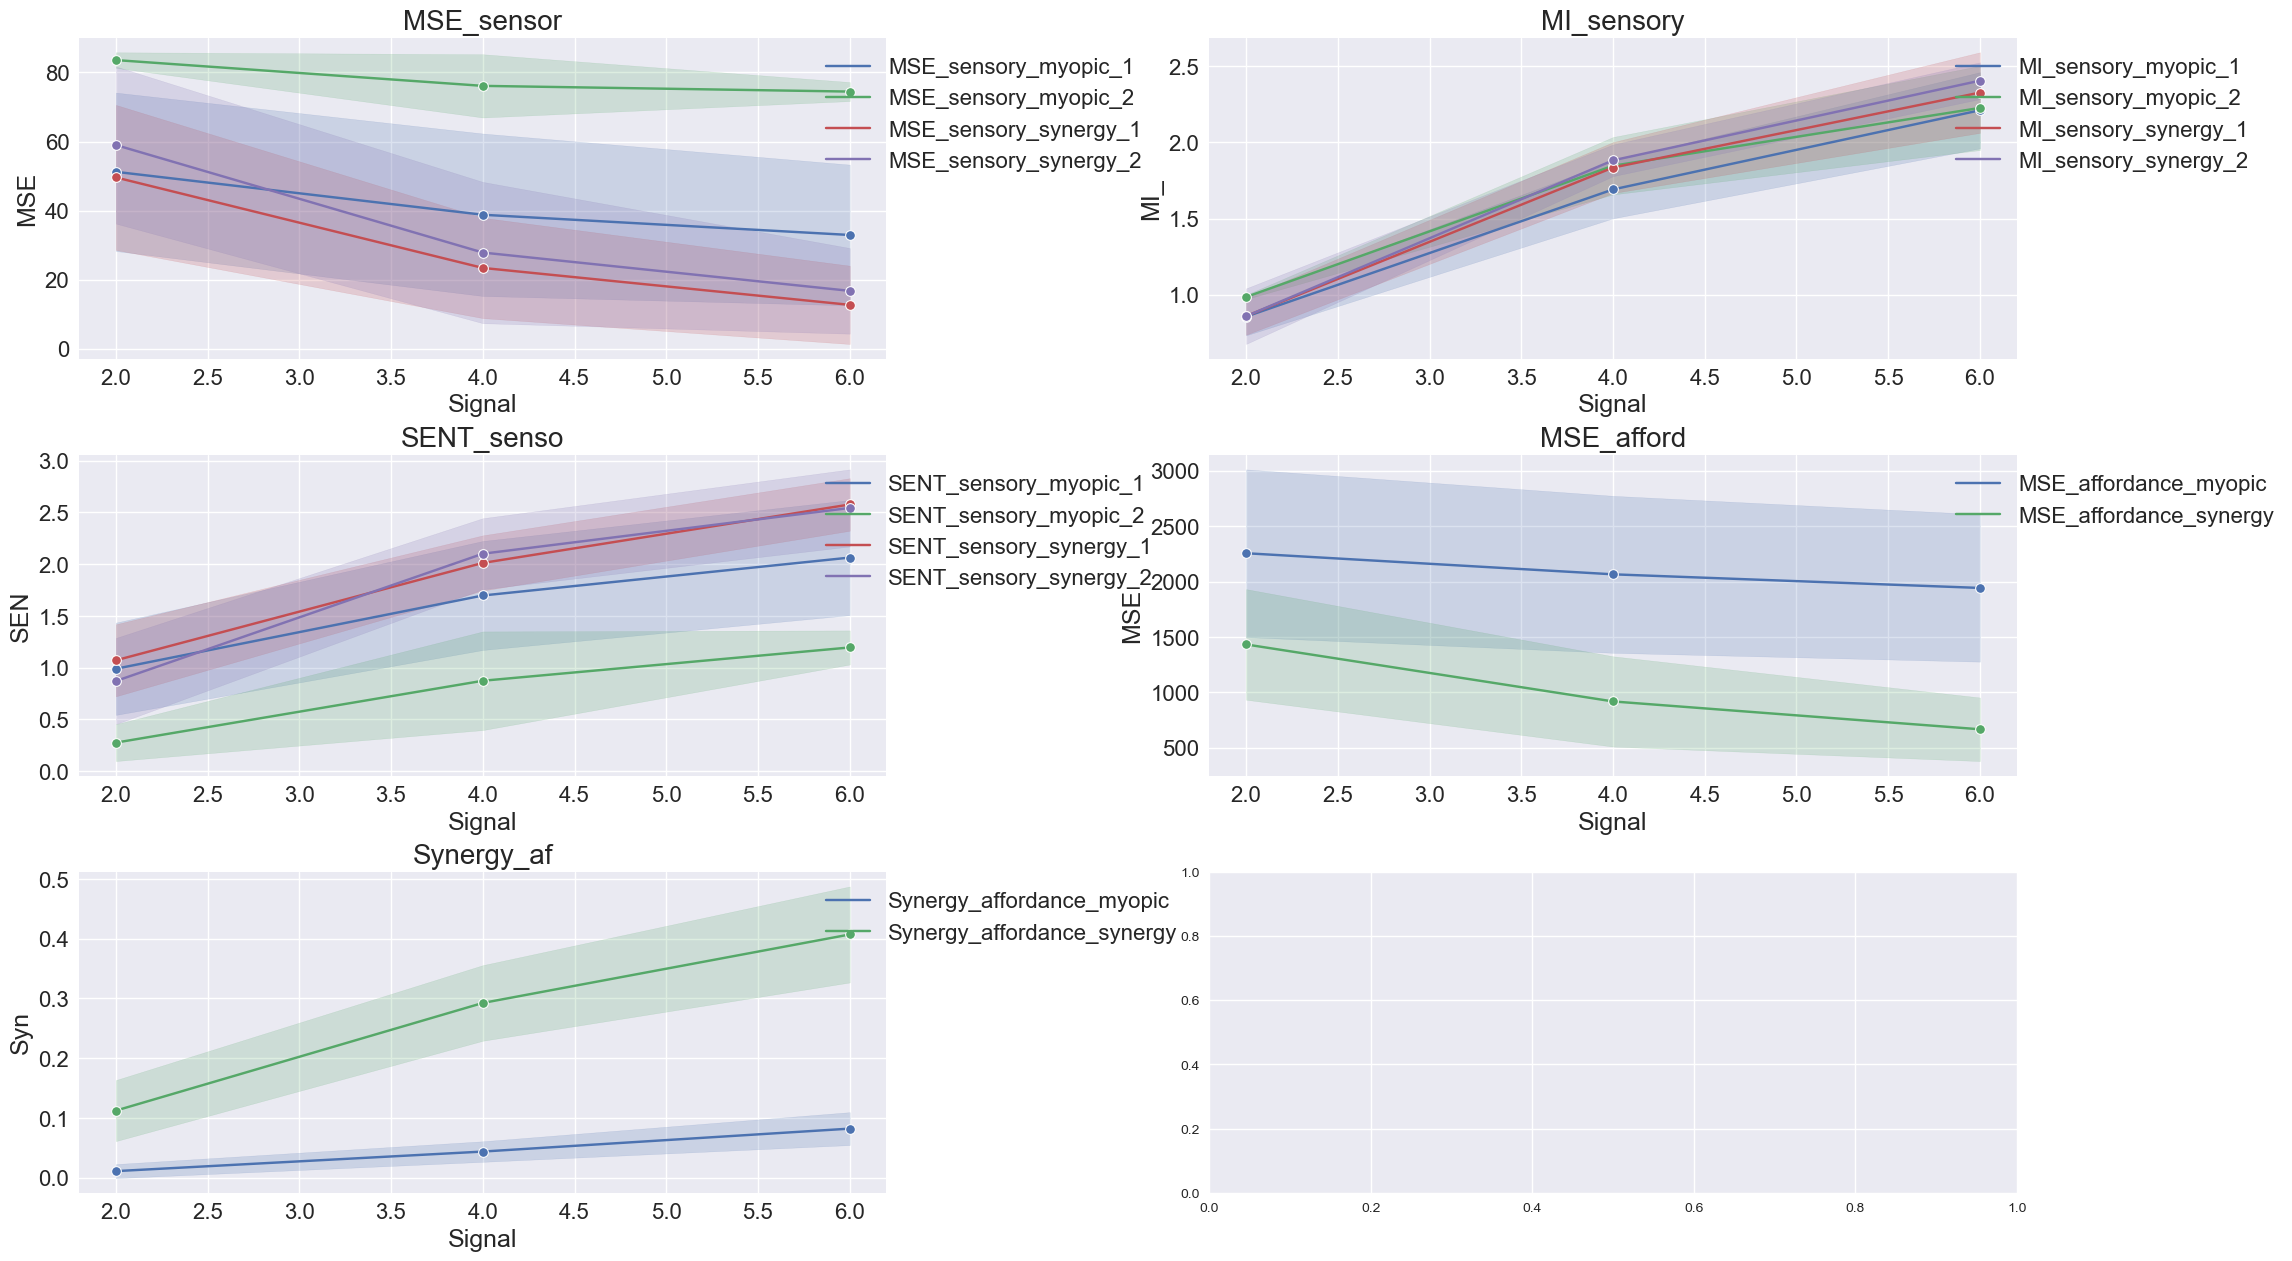

In [252]:
columns = df.columns

fig, ax = plt.subplots(3, 2, figsize=(25, 15))
inds = list(itertools.product([0,1,2], [0,1]))
#fig.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.4)
print(inds)
inds_data = [1, 5, 9, 13, 15, len(columns)]

for i in range(5):
    
    cols = list(columns[inds_data[i]:inds_data[i+1]])
    plot_results(ax[inds[i]], df, cols,
                 cols[0][:3], title=cols[0][:10])


plt.show()

## Let's do a fully worked-out example, for the paper

In [304]:
fitnessmap = dataset[0]
num_s = 4
oneside = Single_Enc_One_Side(fitnessmap.shape[0], num_s)
oneside.fitnessmap = fitnessmap
oneside.main(oneside.random_single_enc(), oneside.random_single_enc())

True

## Now, with these encoders, optimized to the myopic view of fitness each of the sensory modalities has, how much information about the sensory modality itself do we get?

In [305]:
# set fitness map to the basic properties instead of the affordance value
oneside.fitnessmap = np.arange(oneside.side)

In [306]:
oneside.get_entropy(fitnessmap)

7.973571210343888

In [307]:
# get mse for each encoder its basic property
oneside.enc = oneside.enc1
print(oneside.fitnessmap)
print(oneside.enc)
myopic1 = oneside.enc
dec1, mse_myopic_sensory1 = oneside.mmse_decoder()
print("MSE encoder 1 - basic property 1:", mse_myopic_sensory1)

print("")
oneside.enc = oneside.enc2
myopic2 = oneside.enc
dec2, mse_myopic_sensory2 = oneside.mmse_decoder()
print("MSE encoder 2 - basic property 2:", mse_myopic_sensory2)

new_dec1, new_dec2 = oneside.get_decoders()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[2 2 2 2 2 2 2 2 2 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 3 3 3]
MSE encoder 1 - basic property 1: 30.0859375

MSE encoder 2 - basic property 2: 61.68526785714286


In [308]:
new_dec1

array([129.33449074, 129.33449074, 129.33449074, 129.33449074,
       129.33449074, 129.33449074, 129.33449074, 129.33449074,
       129.33449074,  87.4921875 ,  55.76041667,  37.08578431,
        37.08578431,  37.08578431,  37.08578431,  37.08578431,
        37.08578431,  37.08578431,  37.08578431,  37.08578431,
        37.08578431,  37.08578431,  37.08578431,  37.08578431,
        37.08578431,  37.08578431,  37.08578431,  37.08578431,
        55.76041667,  87.4921875 ,  87.4921875 ,  87.4921875 ])

## And how much info about fitness can the decoder get from the two myopic encoders?

In [309]:
algo = Algorithm(fitnessmap.shape[0], num_s)
algo.fitnessmap = fitnessmap

In [310]:
algo.enc1 = oneside.enc1
algo.enc2 = oneside.enc2

In [311]:
algo.decoder, algo.mse = algo.mmse_decoder()

In [312]:
recons_error_myopic = round(algo.mse, 3)
print("Affordance reconstruction error:", recons_error_myopic)

Affordance reconstruction error: 1491.253


In [313]:
repmyopic = algo.represent(showimage=False)

PID for sensory information

In [314]:
oneside.fitnessmap = np.arange(oneside.side)
sensory_encoding = oneside.get_sensory_encodings()
pid_sensory_myopic = oneside.get_pid_measures(3, sensory_encoding)

PID BROJA:
 +---------+--------+--------+
| I_broja |  I_r   |   pi   |
+---------+--------+--------+
|  {0:1}  | 2.0000 | 0.0000 |
|   {0}   | 2.0000 | 0.0000 |
|   {1}   | 2.0000 | 0.0000 |
|  {0}{1} | 2.0000 | 2.0000 |
+---------+--------+--------+


In [315]:
oneside.enc1 = new_dec1.copy()
oneside.enc2 = new_dec2.copy()
print("Mutual information between each encoder and its basic property: ", oneside.get_mutual_info()[:2])
pid_sensory_myopic['{0}'] = oneside.get_mutual_info()[0]
pid_sensory_myopic['{1}'] = oneside.get_mutual_info()[1]

Mutual information between each encoder and its basic property:  (2.0, 2.0)


PID for affordance information

In [316]:
oneside.fitnessmap = fitnessmap
sensory_encoding = oneside.get_affordance_encodings()
pid_affordance_myopic = oneside.get_pid_measures(3, sensory_encoding)

PID BROJA:
 +---------+--------+--------+
| I_broja |  I_r   |   pi   |
+---------+--------+--------+
|  {0:1}  | 4.0000 | 0.0000 |
|   {0}   | 2.0000 | 2.0000 |
|   {1}   | 2.0000 | 2.0000 |
|  {0}{1} | 0.0000 | 0.0000 |
+---------+--------+--------+


## Finally, do the good encoders carry more information about their own sensory data

In [330]:
algo.enc1 = algo.random_enc()
algo.enc2 = algo.random_enc()

In [331]:
recons_error_good = algo.main_loop()
print("Affordance reconstruction error:", round(recons_error_good, 3))

Affordance reconstruction error: 853.367


In [332]:
unique_values, counts = np.unique(algo.enc1, return_counts=True)

# Create a dictionary to store the distribution
good = dict(zip(map(str, unique_values), counts/len(algo.enc1)))

unique_values, counts = np.unique(myopic1, return_counts=True)

# Create a dictionary to store the distribution
bad = dict(zip(map(str, unique_values), counts/len(myopic1)))

In [333]:
good

{'0': 0.125, '1': 0.125, '2': 0.59375, '3': 0.15625}

In [334]:
bad

{'0': 0.0625, '1': 0.53125, '2': 0.28125, '3': 0.125}

In [335]:
# get mse for each encoder its basic property
oneside.fitnessmap = np.arange(oneside.side)
print(oneside.fitnessmap)
print(oneside.enc)
oneside.enc = algo.enc1.copy()
dec1, mse_good_sensory1 = oneside.mmse_decoder()
print("MSE encoder 1 - basic property 1:", mse_good_sensory1)

print("")
oneside.enc = algo.enc2.copy()
myopic2 = oneside.enc
dec2, mse_good_sensory2 = oneside.mmse_decoder()
print("MSE encoder 2 - basic property 2:", mse_good_sensory2)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[0 0 0 0 0 0 0 0 3 3 3 3 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MSE encoder 1 - basic property 1: 36.5375

MSE encoder 2 - basic property 2: 10.3125


In [336]:
oneside.enc1 = algo.enc1.copy()
oneside.enc2 = algo.enc2.copy()

oneside.decoder1 = dec1
oneside.decoder2 = dec2

good_dec1, good_dec2 = oneside.get_decoders()
oneside.decoder1 = good_dec1
oneside.decoder2 = good_dec2

PID for sensory information

In [337]:
sensory_encoding = oneside.get_sensory_encodings()
pid_sensory_comput = oneside.get_pid_measures(3, sensory_encoding)

PID BROJA:
 +---------+--------+--------+
| I_broja |  I_r   |   pi   |
+---------+--------+--------+
|  {0:1}  | 2.5039 | 0.0000 |
|   {0}   | 1.3650 | 0.5414 |
|   {1}   | 1.9626 | 1.1389 |
|  {0}{1} | 0.8236 | 0.8236 |
+---------+--------+--------+


In [338]:
oneside.enc2 = good_dec2.copy()
oneside.enc1 = good_dec1.copy()
print("Mutual information between each encoder and its basic property: ", oneside.get_mutual_info()[:2])
pid_sensory_comput['{0}'] = oneside.get_mutual_info()[0]
pid_sensory_comput['{1}'] = oneside.get_mutual_info()[1]

Mutual information between each encoder and its basic property:  (1.3649917740667208, 1.9625745152068985)


PID for affordance information

In [339]:
oneside.fitnessmap = fitnessmap
sensory_encoding = oneside.get_affordance_encodings()
pid_affordance_comput = oneside.get_pid_measures(3, sensory_encoding)

KeyboardInterrupt: 

In [340]:
plt.style.use('default')

In [341]:
rep1 = oneside.represent_1(showimage=False)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
rep2 = oneside.represent_2(showimage=False)

In [ ]:
repgood = algo.represent(showimage=False)

In [ ]:
#plt.imshow(algo.fitnessmap)

In [ ]:
#plt.imshow(groundtruth)
#plt.savefig("MNIST1_groundtruth.pdf")

In [ ]:
plt.subplot(2, 3, 1)
plt.imshow(groundtruth)
plt.subplot(2, 3, 2)
plt.imshow(rep1)
plt.subplot(2, 3, 3)
plt.imshow(rep2)
plt.subplot(2, 3, 4)
plt.imshow(repmyopic)
plt.subplot(2, 3, 5)
plt.imshow(repgood)
plt.savefig("MNIST1.pdf")

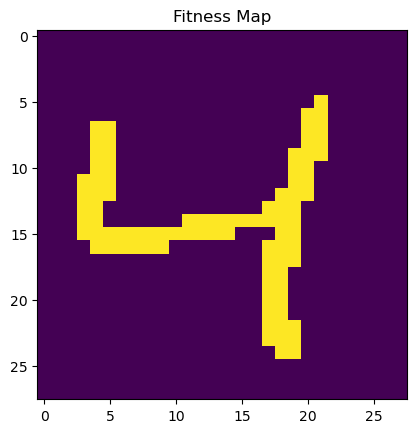

In [319]:
array = dataset[2].copy()

if True:
    inds_1 = array <= 100
    inds_2 = array > 100

    array[inds_1] = 0
    array[inds_2] = 1

fitnessmap = array

plt.title("Fitness Map")
plt.imshow(fitnessmap)
plt.show()

In [342]:
side = 28
signals = 6

oneside = Single_Enc_One_Side(side, signals)
oneside.fitnessmap = fitnessmap
oneside.main(oneside.random_single_enc(), oneside.random_single_enc())
represent1 = oneside.represent_1(showimage=False)
represent2 = oneside.represent_2(showimage=False)

# Now we see how informative these encoders are of their sensory modality
oneside.fitnessmap = np.arange(oneside.side)
oneside.enc = oneside.enc1
sensory_myopic_decoder1, sensory_myopic1 = oneside.mmse_decoder()
print(oneside.enc)
print(sensory_myopic_decoder1)
print("sensory myopic 1", sensory_myopic1)

oneside.enc = oneside.enc2
sensory_myopic_decoder2, sensory_myopic2 = oneside.mmse_decoder()
print("sensory myopic 1", sensory_myopic2)

sensory_encoding = oneside.get_sensory_encodings()
pid_sensory_myopic = oneside.get_pid_measures(3, sensory_encoding, False)
mut_1, mut_2 = oneside.get_mutual_info()[:2]
print("Mutual Myopic", mut_1, mut_2)

# And how much info about fitness can the decoder get from the two myopic encoders?
algo = Algorithm(side, signals)
algo.fitnessmap = fitnessmap
algo.enc1 = oneside.enc1.copy()
algo.enc2 = oneside.enc2.copy()
algo.decoder, algo.mse = algo.mmse_decoder()
myopic_fitness = algo.mse
print("fitness myopic", myopic_fitness)

print("\nGood encoders...")
# Finally, do the good encoders carry more information about their own sensory data?
good_fitness = algo.main_loop()
print("Fitness Good", good_fitness)

represent3 = algo.represent(showimage=False)
oneside.enc = algo.enc1.copy()
_, sensory_good1 = oneside.mmse_decoder()
print("sensory good 1", sensory_good1)

oneside.enc = algo.enc2.copy()
_, sensory_good2 = oneside.mmse_decoder()
print("sensory good 1", sensory_good2)

oneside.enc1 = algo.enc1.copy()
oneside.enc2 = algo.enc2.copy()
sensory_encoding = oneside.get_sensory_encodings()
pid_sensory_comput = oneside.get_pid_measures(3, sensory_encoding, False)

mut_1, mut_2 = oneside.get_mutual_info()[:2]
print("Mutual Good", mut_1, mut_2)

[1 1 3 3 2 2 1 1 2 5 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[10.          3.5         5.66666667  2.5        19.          9.        ]
sensory myopic 1 16.220238095238095
sensory myopic 1 34.56539115646258
Mutual Myopic 2.584962500721156 2.584962500721156
fitness myopic 1368.5234719888285

Good encoders...
Fitness Good 614.6711781156296
sensory good 1 8.196428571428571
sensory good 1 2.4285714285714284
Mutual Good 2.584962500721156 2.584962500721156


Now I need to put all of this together in a little script and run it for a few thousand samples

In [ ]:
def analyze(fitnessmaps, signals=6):
    """
    Calculate, for a <fitnessmap>
    a) The lowest distortion one can get with 6 signals per side
    b) The lowest distortion about the sensory modality one can get with the encoders one gets in a)
    c) The lowest distortion one can get if each encoder tries to minimize fitness distortion independently
    d) The lowest distortion about the sensory modality one can get with the encoders one gets in c)
    """
    
    mf = []
    sm1 = []
    sm2 = []
    mmt1 = []
    mmt2 = []
    gf = []
    sg1 = []
    sg2 = []
    gmt1 = []
    gmt2 = []
    
    for i,fitnessmap in enumerate(fitnessmaps):
        print("Iter", i)
        side = fitnessmap.shape[0]

        print("Myopic encoders...")
        # First we calculate the "myopic encoders" that try to maximize fitness independenty
        oneside = Single_Enc_One_Side(side, signals)
        oneside.fitnessmap = fitnessmap
        oneside.main(oneside.random_single_enc(), oneside.random_single_enc())
        represent1 = oneside.represent_1(showimage=False)
        represent2 = oneside.represent_2(showimage=False)

        # Now we see how informative these encoders are of their sensory modality
        oneside.fitnessmap = np.arange(oneside.side)
        oneside.enc = oneside.enc1
        _, sensory_myopic1 = oneside.mmse_decoder()
        sm1.append(sensory_myopic1)
        oneside.enc = oneside.enc2
        myo_enc1 = oneside.enc1
        myo_enc2 = oneside.enc2
        _, sensory_myopic2 = oneside.mmse_decoder()
        sm2.append(sensory_myopic2)
        sensory_encoding = oneside.get_sensory_encodings()
        pid_sensory_myopic = oneside.get_pid_measures(3, sensory_encoding, False)
        mut_1, mut_2 = oneside.get_mutual_info()
        
        mmt1.append(mut_1)
        mmt2.append(mut_2)

        # And how much info about fitness can the decoder get from the two myopic encoders?
        algo = Algorithm(side, signals)
        algo.fitnessmap = fitnessmap
        algo.enc1 = oneside.enc1
        algo.enc2 = oneside.enc2
        algo.decoder, algo.mse = algo.mmse_decoder()
        myopic_fitness = algo.mse
        
        mf.append(myopic_fitness)

        print("Good encoders...")
        # Finally, do the good encoders carry more information about their own sensory data?
        algo.enc1 = oneside.enc1
        algo.enc2 = oneside.enc2
        good_fitness = algo.main_loop()
        gf.append(good_fitness)
        
        good_enc1 = algo.enc1
        good_enc2 = algo.enc2
        
        represent3 = algo.represent(showimage=False)
        oneside.enc = algo.enc1
        _, sensory_good1 = oneside.mmse_decoder()
        sg1.append(sensory_good1)
        
        oneside.enc = algo.enc2
        oneside.mmse_decoder()
        _, sensory_good2 = oneside.mmse_decoder()
        sg2.append(sensory_good2)
        sensory_encoding = oneside.get_sensory_encodings()
        pid_sensory_comput = oneside.get_pid_measures(3, sensory_encoding, False)
        mut_1, mut_2 = oneside.get_mutual_info()
        
        gmt1.append(mut_1)
        gmt2.append(mut_2)

    return  {"myopic_fitness":np.mean(mf),
             "sensory_myopic1":np.mean(sm1),
             "sensory_myopic2":np.mean(sm2),
             "myopic_mutal_inf1":np.mean(mmt1),
             "myopic_mutal_inf2":np.mean(mmt2),
             "good_fitness": np.mean(gf),
             "sensory_good1":np.mean(sg1),
             "sensory_good2":np.mean(sg2),
             "good_mutual_inf1":np.mean(gmt1),
             "good_mutual_inf2":np.mean(gmt2),
            }, myo_enc1, myo_enc2, good_enc1, good_enc2



In [ ]:
fitnesmaps = []
for array in dataset[:10]:
    inds_1 = array > 0
    inds_2 = array == 0

    array[inds_1] = 0
    array[inds_2] = 1
    
    fitnesmaps.append(array)

In [ ]:
result = analyze(cats_grayscale[:1])

In [ ]:
for ar in result[1:]:
    # Calculate the frequency distribution
    unique_values, counts = np.unique(ar.flatten(), return_counts=True)

    # Create a dictionary to store the distribution
    distribution_dict = dict(zip(map(str, unique_values), counts/len(ar.flatten())))

    entropy_fitness = dit.Distribution(distribution_dict)

    print(dit.shannon.entropy(entropy_fitness))

In [ ]:
new_df = pd.DataFrame([result[0]])
new_df.round(2)

# Tiny ImageNet

Let's try a similar exercise with grayscale images of cats!

In [242]:
from matplotlib.image import imread

In [243]:
one_image = imread("dataset/n02123045_0_gray.jpeg")

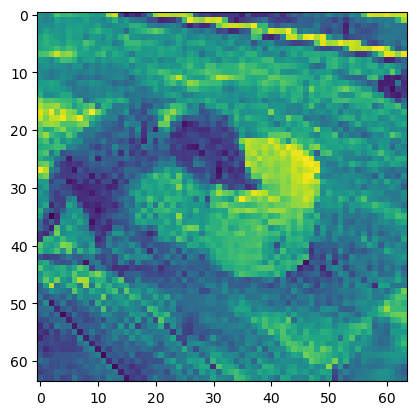

In [244]:
plt.imshow(one_image)

In [245]:
%cd ../dataset/grayscale/

[Errno 2] No such file or directory: '../dataset/grayscale/'
/Users/md623/PhD/synergyPaper


In [246]:
import os
cats_grayscale = []
for path in os.listdir("dataset/"):
    if path[-4:] == 'jpeg':
        cats_grayscale.append(imread("dataset/" + path))


In [247]:
"""from os import listdir
cats_grayscale = []
for path in listdir():
    if path[-4:] == 'jpeg':
        cats_grayscale.append(imread(path))"""

"from os import listdir\ncats_grayscale = []\nfor path in listdir():\n    if path[-4:] == 'jpeg':\n        cats_grayscale.append(imread(path))"

In [248]:
cats_grayscale = np.array(cats_grayscale)

In [249]:
cats_grayscale.shape

(501, 64, 64)

In [ ]:
with open('cats_grayscale.pkl', 'wb') as pfile:
    pkl.dump(cats_grayscale, pfile)

In [ ]:
with open('cats_grayscale.pkl', 'rb') as pfile:
    cats_grayscale = pkl.load(pfile)

Another worked-out example for the paper

In [ ]:
n = 4
plt.imshow(cats_grayscale[n])

In [ ]:
groundtruth = cats_grayscale[n]

plt.imshow(groundtruth)
plt.savefig("cat_groundtruth.pdf")

In [ ]:
cat2 = Single_Enc_One_Side(64, 20)
cat2.fitnessmap = groundtruth

In [ ]:
cat2.main(cat2.random_single_enc(), cat2.random_single_enc())

In [ ]:
rep1 = cat2.represent_1()

In [ ]:
rep2 = cat2.represent_2()

In [ ]:
algo = Algorithm(64, 20)
algo.fitnessmap = groundtruth
algo.enc1 = cat2.enc1
algo.enc2 = cat2.enc2

In [ ]:
algo.decoder, mse = algo.mmse_decoder()

In [ ]:
mse

In [ ]:
repmyopic = algo.represent()

In [ ]:
algo.main_loop()

In [ ]:
repgood = algo.represent()

In [ ]:
plt.subplot(2, 3, 1)
plt.imshow(groundtruth)
plt.subplot(2, 3, 2)
plt.imshow(rep1)
plt.subplot(2, 3, 4)
plt.imshow(rep2)
plt.subplot(2, 3, 5)
plt.imshow(repmyopic)
plt.subplot(2, 3, 6)
plt.imshow(repgood)
plt.savefig("cat0.pdf")

# Same Encoder for Many Fitness Maps

I think I have all the data I wanted. One final thing, perhaps, is to see what happens when we optimize the two encoders for, say, 50 cats. I guess they will be even more attuned to their own sensory data.

First, as a benchmark, I calculate the best encoder when the distortion measure is related to the sensory data itself.

In [230]:
benchmark = Single_Enc_One_Side(36, 6)

In [231]:
fitnessmapT = np.array([list(range(36))] * 36)

In [232]:
fitnessmap = fitnessmapT.T

In [233]:
benchmark.fitnessmap = fitnessmap

In [234]:
benchmark.enc = benchmark.random_single_enc()

In [235]:
benchmark.main_loop()

3.083333333333333

In [236]:
enc_regular = np.array(
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5])

In [237]:
benchmark.enc = enc_regular

In [238]:
benchmark.mmse_decoder()

(array([ 2.5,  8.5, 14.5, 20.5, 26.5, 32.5]), 2.9166666666666665)

Now I calculate the best encoders for, say, 50 different fitness maps

In [250]:
class ManyFitnessMaps(Algorithm):

    """Here self.fitnessmap is a collection of fitnessmaps"""

    def mmse_decoder(self):
        """
        Calculate the mmse decoder for two encoders,
        given a fitnessmap and a maximum number of signals
        """
        pairs = list(it.product(range(self.signals), repeat=2))
        decoder = np.empty((self.signals, self.signals))
        samples = []
        mse = []
        for pair in pairs:
            values = self.mmse_pairofsignals(*pair)
            decoder[pair] = values.mean()
            samples.append(values.shape[0])
            new_mse = ((values - values.mean()) ** 2).mean()
            mse.append(new_mse)
        norm_samples = np.array(samples) / np.array(samples).sum()
        return decoder, np.array(mse) @ norm_samples

    def many_mmse_decoders(self):
        mses = []
        fitnessmap_bak = self.fitnessmap.copy()
        for fitnessmap in fitnessmap_bak:
            self.fitnessmap = fitnessmap
            _, mse = self.mmse_decoder()
            mses.append(mse)
        self.fitnessmap = fitnessmap_bak
        return np.array(mses).mean()

    def modify_enc(self, pair):
        encoders = {0:self.enc1, 1:self.enc2}
        index, enc = pair
        enc1_backup = self.enc1.copy()
        enc2_backup = self.enc2.copy()
        actual_signal = encoders[enc][index]
        loop = [signal for signal in range(self.signals) if signal != actual_signal]
        for signal in loop:
            encoders[enc][index] = signal
            mse = self.many_mmse_decoders()
            if mse < self.mse:
                print(mse)
                self.mse = mse
                return True
        self.enc1 = enc1_backup
        self.enc2 = enc2_backup
        return False

In [251]:
many = ManyFitnessMaps(36, 6)

In [252]:
many.fitnessmap = cats_grayscale[50:100]
many.enc1 = many.random_enc()
many.enc2 = many.random_enc()

In [253]:
many.main_loop()

2487.963480350271
2450.5817527172876
2445.1384724048826
2411.885816959829
2409.9553453703893
2408.9016290330646
2397.4677082709723
2365.9994071864385
2362.7059428119283
2351.177652753997
2349.551214992465
2347.4005032933474
2322.9773623436377
2287.7959175176093
2274.7344813932978
2268.09253933593
2267.7174028527947
2242.9911171682097
2239.3988076817554
2173.933345021589
2169.3028087090593
2153.2288270821086
2135.7575447975305
2119.3524000570537
2115.4813870694697
2110.131633374669
2108.6389393708355
2105.927501591588
2084.3527512325772
2065.118598147772
2059.6439695733793
2057.077123983441
2056.8921643435847
2007.2585039189332
1995.0973881179902
1992.0735086552359
1991.4070866689704
1987.2376213998361
1986.1888381761198
1981.9247047956328
1972.1390418419871
1952.21485744269
1951.878950123961
1918.8672128821281
1902.3271869035368
1889.2300376661508
1850.9161835397506
1841.5255901008422
1837.1331849262485
1834.0581434748688
1817.6293095968877
1816.9457794399943
1793.6392558570528
1785.91

1014.6136495815662

In [254]:
many.enc1

array([4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

In [255]:
many.enc2

array([5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0])

In [256]:
many.mse

1014.6136495815662

In [257]:
many.many_mmse_decoders()

1014.6136495815662

array([[109.24023438, 109.24023438, 109.24023438, ..., 110.42838542,
        110.42838542, 110.42838542],
       [109.24023438, 109.24023438, 109.24023438, ..., 110.42838542,
        110.42838542, 110.42838542],
       [109.24023438, 109.24023438, 109.24023438, ..., 110.42838542,
        110.42838542, 110.42838542],
       ...,
       [117.36067708, 117.36067708, 117.36067708, ..., 123.94097222,
        123.94097222, 123.94097222],
       [117.36067708, 117.36067708, 117.36067708, ..., 123.94097222,
        123.94097222, 123.94097222],
       [117.36067708, 117.36067708, 117.36067708, ..., 123.94097222,
        123.94097222, 123.94097222]])

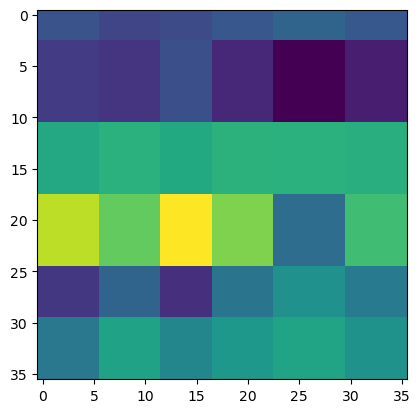

In [258]:
# Here we see that when you try to optimize for various different pictures you end up developing
# a more or less regular tiling: as informative about sensory input as the number of signals allows
many.represent()

# Best encoder for a Gaussian

Now, for the paper, let's calculate the best encoder for a Gaussian

In [ ]:
from scipy.stats.distributions import norm

In [ ]:
plt.plot(np.linspace(-4, 4, num=36), norm.pdf(np.linspace(-4, 4, num=36)))

In [ ]:
gauss = Single_Enc_One_Side(36, 6)

In [ ]:
gauss.fitnessmap = norm.pdf(np.linspace(-4, 4, num=36))

In [ ]:
gauss.enc = gauss.random_single_enc()

In [ ]:
gauss.main_loop()

In [ ]:
gauss.enc

In [ ]:
gauss.decoder2 = gauss.decoder
gauss.enc2 = gauss.enc

In [ ]:
enc_arr = gauss.represent_2()

In [ ]:
sensory = np.arange(36)
fitnessmap = gauss.fitnessmap
plt.plot(sensory, fitnessmap)
plt.xlabel('basic-property value')
plt.ylabel('affordance value')

fig.tight_layout()
# plt.savefig("two_essence_kinds_rd_with_majority.pdf")
ax1.plot(sensory, fitnessmap)

plt.savefig("gaussian_energy_array.pdf")
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
sensory = np.arange(36)
fitnessmap = gauss.fitnessmap
ax1.plot(sensory, fitnessmap)
ax1.set_xlabel('basic-property value')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('affordance value')
ax1.tick_params('y')
# ax1.axis([0, dit.shannon.entropy(two_essence_dist), 0, max(distortion)])

ax2 = ax1.twinx()
ax2.imshow(enc_arr, alpha=.5)
# ax2.axis([0, dit.shannon.entropy(two_essence_dist), -10, 0])

fig.tight_layout()
# plt.savefig("two_essence_kinds_rd_with_majority.pdf")
ax1.plot(sensory, fitnessmap)

plt.savefig("optimal_codec_gauss.pdf")
plt.show()

## Leftovers

In [ ]:
"""def quantize_fitnessmap(fm, n=5):
    fm_flatten = fm.flatten()
    mini, maxi = np.min(fm_flatten), np.max(fm_flatten)

    intervals = np.linspace(mini, maxi, n)
    inds = []
    for i,interval in enumerate(intervals):
        if i == 0:
            inds.append(fm < intervals[i+1])
        elif i < n - 1:
            inds.append((fm > intervals[i]) & (fm <= intervals[i+1]))
        

    for j,ind in enumerate(inds):
        fm[ind] = np.mean([intervals[j], intervals[j+1]])
                
    return fm"""